##### Import the necessary packages

In [1]:
import os
import cv2
import imutils
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist

##### Define Utiliy Function

In [2]:
def detect_people(frame, net, ln, personIdx):
    # grab the dimensions of the frame
    (H, W) = frame.shape[:2]
    
    # initialize the list to store box results, confidence, coordinates, centroid
    results = []
    boxes = []
    centroids = []
    confidences = []
    
    # construct a blob from the input frame and then perform a forward pass to the yolo detector
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    l_output = net.forward(ln)

    # loop over each of the layer outputs
    for output in l_output:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter the person and weak classification
            if classID == personIdx and confidence > MIN_CONF:
                # scale the bounding box coordinates back relative to the size of the image
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # update our list of bounding box coordinates, centroids, and confidences
                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))

    # apply non-maxima suppression to suppress weak, overlapping
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            r = (confidences[i], (x, y, x + w, y + h), centroids[i])
            results.append(r)

    # return the list of results
    return results

In [3]:
def get_min_dist(input_video, num_iter, net, ln, personIdx):
    #Check if camera opened successfully
    cap = cv2.VideoCapture(input_video)
    avgh_list = []
    # Read until video is completed
    counter = 1
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            frame = imutils.resize(frame, width=700)
            results = detect_people(frame, net, ln, personIdx)
            # Atleast one person should be detected
            if len(results) > 0:
                # Get the average height of the person in the frame
                avgh = np.array([i[3] - i[1] for i in np.array(results)[:,1]]).mean()
                avgh_list.append(avgh)
                # update the counter
                counter = counter + 1
            # Break the loop after 50 iterations:
            if counter == (num_iter + 1):
                break
        else: 
            break
    # When everything done, release the video capture object
    cap.release()
    # Closes all the frames
    cv2.destroyAllWindows()
    # Get average height in pixels
    min_dist = np.array(avgh_list).mean()
    return min_dist

##### Configuration

In [4]:
# Model path directory
MODEL_PATH = "model"

# Flag indicating if NVIDIA CUDA GPU should be used
USE_GPU = True

# Minimum probability to filter out weak detections
MIN_CONF = 0.3

# threshold when applying non-maxima suppression
NMS_THRESH = 0.3

# Wether to display the video
display = 1

# Input Video
input_video = "test_videos/pedestrians.mp4"

# Ouput Video
output_file = "output.avi"

writer = None

##### Loading the YOLO classifier 

Download the Weight, config, Coco names files from the respective link in the "model" directory:

- yolo.weigths = "https://drive.google.com/uc?export=download&id=17Tolx6EAKO4tVO505Dbrr_CMTfBwXaGT"
- yolov3.cfg = "https://drive.google.com/uc?export=download&id=1l4N7tSaQi5n40eHKC_B2mNZL8vUPUqNo"
- coco.names = "https://drive.google.com/uc?export=download&id=1rqGCUn4D6yNb9be7lTgpFImnP7z6yl5f"

In [5]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([MODEL_PATH, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([MODEL_PATH, "yolov3.weights"])
configPath = os.path.sep.join([MODEL_PATH, "yolov3.cfg"])

# Load the serialized pretrained model
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
# check if we are going to use GPU
if USE_GPU:
    # set CUDA as the preferable backend and target
    print("Settting backend and target to CUDA...")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    
# determine only the output layer names that we need from YOLO detector
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

Settting backend and target to CUDA...


##### Streaming the input video

In [6]:
# Getting the ID for "person" class
personIdx = LABELS.index("person")

In [7]:
# Create a VideoCapture object
cap = cv2.VideoCapture(input_video)

In [8]:
# Minimum distance (in pixels) for implementing social distancing
num_iter = 10
MIN_DISTANCE = get_min_dist(input_video, num_iter, net, ln, personIdx)
print("Minimum Pixel to set threshold for Social distancing violation is {}".format(MIN_DISTANCE))

Minimum Pixel to set threshold for Social distancing violation is 55.65961538461538


In [10]:
# Social Distance Monitoring Tracker consist of number of people detected, number of people violated and social distancing Index
tracker = []
# loop over the frames from the video stream
while True:
    # read the next frame from the file
    (grabbed, frame) = cap.read()

    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break

    # resize the frame and then detect people (and only people) in it
    frame = imutils.resize(frame, width=700)
    results = detect_people(frame, net, ln, personIdx)

    # initialize the set of indexes that violate the minimum social distance
    violate = set()

    # ensure there are *at least* two people detections (required in order to compute our pairwise distance maps)
    if len(results) >= 2:
        centroids = np.array([r[2] for r in results])
        D = dist.cdist(centroids, centroids, metric="euclidean")

        # loop over the upper triangular of the distance matrix
        for i in range(0, D.shape[0]):
            for j in range(i + 1, D.shape[1]):
                if D[i, j] < MIN_DISTANCE:
                    violate.add(i)
                    violate.add(j)

    # loop over the results
    for (i, (prob, bbox, centroid)) in enumerate(results):
        # extract the bounding box and centroid coordinates, then initialize the color of the annotation
        (startX, startY, endX, endY) = bbox
        (cX, cY) = centroid
        color = (255, 0, 0)

        # if the index pair exists within the violation set, then update the color
        if i in violate:
            color = (0, 0, 255)

        # draw (1) a bounding box around the person and (2) the centroid coordinates of the person
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 1)
        cv2.circle(frame, (cX, cY), 3, color, 1)

    # draw the total number of social distancing violations on the output frame
    font_scale = 1
    font = cv2.FONT_HERSHEY_PLAIN
    # set the rectangle background to white
    rectangle_bgr = (255, 255, 255)
    # Social Distancing Index scale 1 Good; 0 Poor
    num_p = len(results)
    num_v = len(violate)
    SDidx = 1 - (num_v/num_p)
    SDidx = np.round(SDidx, 2)
    
    # draw the total number of social distancing violations on the output frame
    r = (num_p, num_v, SDidx)
    tracker.append(r)
    
    text = "Social Distancing Violations: {}".format(len(violate))
    cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 2)

    # check to see if the output frame should be displayed to our screen
    if display > 0:
        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # if an output video file path has been supplied and the video writer has not been initialized, do so now
    if  output_file != "" and writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(output_file, fourcc, 12, (frame.shape[1], frame.shape[0]), True)

    # if the video writer is not None, write the frame to the output video file
    if writer is not None:
        writer.write(frame)

# When everything done, release the video capture and video write objects
cap.release()
writer.release()

# Closes all the frames
cv2.destroyAllWindows() 

##### Analysis

In [31]:
import seaborn as sns
import matplotlib as plt
sns.set(style='whitegrid', palette="deep")
%matplotlib inline

In [32]:
tracker_df = pd.DataFrame(tracker, columns = ["#People", "#Violation", "SD_index"])

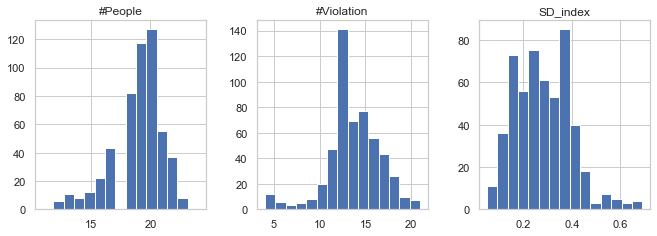

In [37]:
ax = tracker_df.hist(bins=15, figsize=(15, 8), layout=(2, 4))

In [29]:
tracker_df.describe()

,#People,#Violation,SD_index
count,530.000000,530.000000,530.000000
mean,18.900000,13.688679,0.281321
std,2.141365,2.957683,0.117182
min,11.000000,4.000000,0.050000
25%,18.000000,12.000000,0.180000
50%,19.000000,14.000000,0.280000
75%,20.000000,16.000000,0.350000
max,24.000000,21.000000,0.690000
